In [17]:
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [4]:
quickdraw_dir = Path('datasets')
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [5]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [6]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [7]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [9]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [10]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [12]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [13]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

2023-07-06 14:32:59.785308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 14:32:59.813003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 14:32:59.813069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 14:32:59.814400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 14:32:59.814444: I tensorflow/compile

In [14]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.02941173  0.34117648  0.        ]
  [ 0.          0.10196078  0.        ]
  [-0.01680672  0.09411764  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.02525252 -0.05882353  0.        ]
  [-0.02525252 -0.01568627  0.        ]
  [-0.06060606 -0.01568627  0.        ]
  ...
  [-0.04545455  0.0745098   1.        ]
  [ 0.72727275 -0.827451    0.        ]
  [ 0.          0.          1.        ]]

 [[-0.16862744  0.13259669  0.        ]
  [-0.19607842  0.22099446  1.        ]
  [ 0.36862743 -0.37016574  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.01960784  0.35185188  0.        ]
  [ 0.02352941  0.0138889   0.        ]
  [ 0.11372548 -0.00462967  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

2023-07-06 14:33:19.198654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-07-06 14:33:19.198890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


2023-07-06 14:34:09.626012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-07-06 14:34:09.626288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


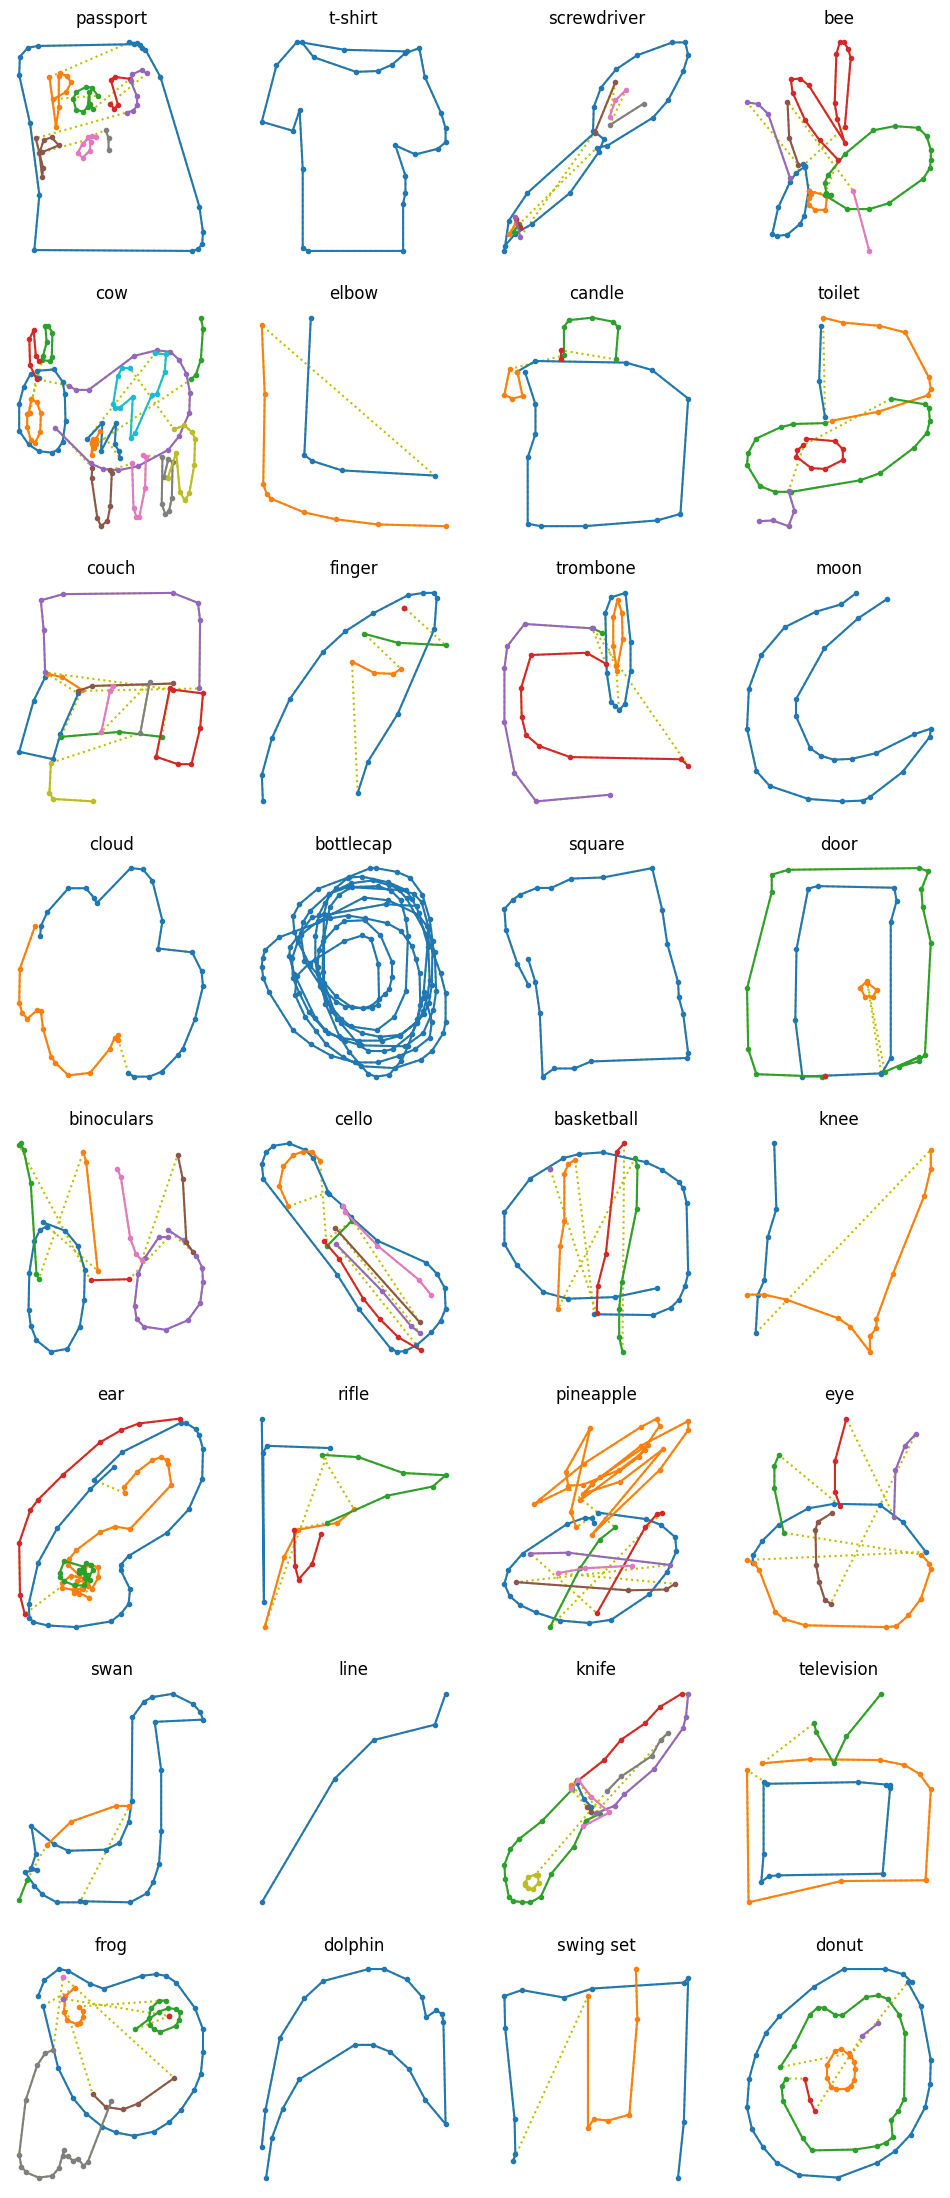

In [18]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")


def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()


for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

2023-07-06 14:35:05.497045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-07-06 14:35:05.497364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


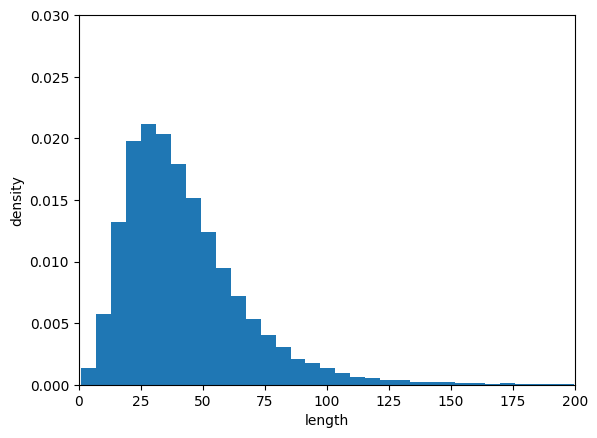

In [19]:
# Most sketches are composed of less than 100 points:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [20]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

In [21]:
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [26]:
for x in cropped_train_set:
    print(x[0].shape)
    print(x[1].shape)
    print(x[0][0])
    break

(32, 100, 3)
(32,)
tf.Tensor(
[[-0.39215684 -0.09090909  0.        ]
 [-0.06274512  0.08264463  0.        ]
 [-0.09019607  0.06611571  0.        ]
 [-0.25490198 -0.12396695  0.        ]
 [-0.03137255  0.23966941  0.        ]
 [-0.07058824  0.34710744  0.        ]
 [ 0.20392157 -0.02479339  0.        ]
 [ 0.05882354  0.07438016  0.        ]
 [ 0.09019607  0.04132235  0.        ]
 [ 0.2392157  -0.11570251  0.        ]
 [ 0.03137255  0.16528928  0.        ]
 [ 0.03137255  0.10743797  0.        ]
 [ 0.12549019 -0.23966938  0.        ]
 [ 0.02745098  0.18181819  0.        ]
 [ 0.02745098  0.0578512   0.        ]
 [ 0.05882353  0.10743803  0.        ]
 [ 0.05490196  0.03305787  0.        ]
 [ 0.05098039 -0.4876033   1.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.     

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])

In [29]:
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2


2023-07-06 14:38:35.860294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 14:38:35.861527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 14:38:35.862712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 107813/Unknown - 1657s 15ms/step - loss: 4.1217 - accuracy: 0.1634 - sparse_top_k_categorical_accuracy: 0.3637

2023-07-06 15:06:12.461385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2023-07-06 15:06:12.461751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2023-07-06 15:06:12.901172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with d

107813/107813 [==============================] - 1688s 16ms/step - loss: 4.1217 - accuracy: 0.1634 - sparse_top_k_categorical_accuracy: 0.3637 - val_loss: 3.1039 - val_accuracy: 0.3038 - val_sparse_top_k_categorical_accuracy: 0.5892
Epoch 2/2
  5068/107813 [>.............................] - ETA: 25:39 - loss: 3.0656 - accuracy: 0.3138 - sparse_top_k_categorical_accuracy: 0.5976

KeyboardInterrupt: 

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)